### N-Gram Language Model

This notebook will train country and a heavy metal ngram models for the given NGRAM value. It generates and prints sequences using these models as well as evaluates perplexity on the validation sets. Analysis of tuning the NGRAM value can be found at the bottom of the notebook. 

When running, NGRAM (the n value to use) and NUM_SEQ_TO_GENERATE (the number of new sequences to create with the trained model) can be adjusted. 

In [126]:
#imports 
import pandas as pd
import ngram_laplace_lm_model as lm
import numpy as np
import matplotlib.pyplot as plt

import utils 

In [127]:
# special tokens 
SENTENCE_BEGIN = "<s>"
SENTENCE_END = "</s>"

# filepaths 
country_train_filepath = "data/country_train.csv"
country_val_filepath = "data/country_val.csv"
country_test_filepath = "data/country_test.csv"

metal_train_filepath = "data/metal_train.csv"
metal_val_filepath = "data/metal_val.csv"
metal_test_filepath = "data/metal_test.csv"

# constants to change 
NGRAM = 4
NUM_SEQ_TO_GENERATE = 10 # how many lines to generate with our models 
VERBOSE = True

In [128]:
# read in data
country_train_lyrics = pd.read_csv(country_train_filepath, header=None)[0].to_list()
country_val_lyrics = pd.read_csv(country_val_filepath, header=None)[0].to_list()
print("Number of training lines for Country:", len(country_train_lyrics))
print("Number of validation lines for Country:", len(country_val_lyrics))
print()

metal_train_lyrics = pd.read_csv(metal_train_filepath, header=None)[0].to_list()
metal_val_lyrics = pd.read_csv(metal_val_filepath, header=None)[0].to_list()
print("Number of training lines for Heavy Metal:", len(metal_train_lyrics))
print("Number of validation lines for Heavy Metal:", len(metal_val_lyrics))

Number of training lines for Country: 149771
Number of validation lines for Country: 18610

Number of training lines for Heavy Metal: 149771
Number of validation lines for Heavy Metal: 18610


In [129]:
def create_ngram_laplace_model(training_sequences: list, ngram: int = NGRAM, verbose: bool = True):
	"""
	 Creates a trained n-gram language model using Laplace Smoothing using the given training data 

	 Args:
		training_sequences (list): a list of training sequence strings
		ngram (int): the n-gram order of the language model to create
		verbose (bool): if True, prints information about the training data 

	Returns:
		A trained NGramLaplaceLanguageModel
	"""
	tokens = utils.tokenize(training_sequences, ngram)
	model = lm.NGramLaplaceLanguageModel(ngram)
	model.train(tokens, verbose=verbose)

	return model

In [130]:
print("Country Laplace Model:")
laplace_country_model = create_ngram_laplace_model(country_train_lyrics)

Country Laplace Model:


Number of tokens: 2099943
N-gram examples: [('<s>', '<s>', '<s>', 'i'), ('<s>', '<s>', 'i', "'ve"), ('<s>', 'i', "'ve", 'seen')]
Vocabulary Size: 11236


In [131]:
print("Heavy Metal Laplace Model:")
laplace_metal_model = create_ngram_laplace_model(metal_train_lyrics)

Heavy Metal Laplace Model:
Number of tokens: 1846891
N-gram examples: [('<s>', '<s>', '<s>', 'my'), ('<s>', '<s>', 'my', 'journey'), ('<s>', 'my', 'journey', 'began')]
Vocabulary Size: 14350


#### Generate New Sequences 

In [132]:
# method to help format generated sentences 
def clean_lyric(lyric_tokens: list) -> str:
    """
    Return the given sequence of tokens as a single string without special tokens 
    Args:
        lyric_tokens (list): list of tokens for the generated sequence

    Returns:
        The tokens joined in a single string without special characters 

    """
    lyric_str = ' '.join(lyric_tokens)
    return lyric_str.replace(SENTENCE_BEGIN, '').replace(SENTENCE_END, '').strip()

In [133]:
print("Country Generated Lyrics:\n")
for i in range(NUM_SEQ_TO_GENERATE):
    lyric_tokens = laplace_country_model.generate_sentence()
    print(clean_lyric(lyric_tokens))

Country Generated Lyrics:

santa 's gon na get through it
and say that my
i 've got her wrapped around your fingertips
and who 's got the whole world in tune
'cause when everything is fine . but when the sun burns out
and ever , amen
who have to dance within the flame
so , make it better
and grandma was n't old
i got plans of bein in a warmer town come summer time ( change `` tree '' to gift '' )


In [134]:
print("Heavy Metal Generated Lyrics:\n")
for i in range(NUM_SEQ_TO_GENERATE):
    lyric_tokens = laplace_metal_model.generate_sentence()
    print(clean_lyric(lyric_tokens))

Heavy Metal Generated Lyrics:

do n't you ever say die
the black night sighs .
pray for new life to begin
this blood i bleed , unholy incision
only loss fills my void
sharing becomes closer
morale –  – morale
and as he walked through the valley in thunder and rain
take tons of loads in your kisser
the stars are the molecules in the next life


#### Evaluate Perplexity

We will compute the mean and median perplexity on the validation data, which is distinct from the data used to train the model. Since the other models truncate their inputs to a fixed size, we give an optional parameter to truncate each line so that perplexity is more comparable across models

In [135]:
def get_perplexities(model, lines: list, ngram: int=NGRAM, should_truncate: bool=False):
    """
    Finds the mean perplexity for each of the given test sequences using the given model

    Args:
        model : the  N-gram Language Model 
        lines (list): a list of strings of data to evaluate perplexity on 
        ngram (int): the n-gram order used by the model
        should_truncate (bool): an optional truncation parameter that shortens the sequences to the same length used by RNNs
                                (to make perplexity more comparable between models)

    Returns: 
        perplexities (list): list of perplexity values 
    """
    perplexities = []
    for line in lines:
        test_tokens = utils.tokenize_line(line, ngram)
        if should_truncate:
            test_tokens = test_tokens[:10]

        perplexities.append(model.perplexity(test_tokens))

    return perplexities


def average_perplexity(model, lines: list, ngram: int=NGRAM, should_truncate: bool=False): 
    """
    Evaluates the given model by finding the mean perplexity of the given test sequences. 

    Args:
        model : the  N-gram Language Model 
        lines (list): a list of strings of data to evaluate perplexity on 
        ngram (int): the n-gram order used by the model
        should_truncate (bool): an optional truncation parameter that shortens the sequences to the same length used by RNNs
                                (to make perplexity more comparable between models)

    Returns: average perplexity over the given sequences 
    """
    perplexities = get_perplexities(model, lines, ngram, should_truncate)
    return np.mean(perplexities)


def median_perplexity(model, lines: list, ngram: int=NGRAM, should_truncate: bool=False): 
    """
    Evaluates the given model by finding the median perplexity of the given test sequences. 

    Args:
        model : the  N-gram Language Model 
        lines (list): a list of strings of data to evaluate perplexity on 
        ngram (int): the n-gram order used by the model
        should_truncate (bool): an optional truncation parameter that shortens the sequences to the same length used by RNNs
                                (to make perplexity more comparable between models)

    Returns: median perplexity over the given sequences 
    """
    perplexities = get_perplexities(model, lines, ngram, should_truncate)
    return np.median(perplexities)


print("MEAN PERPLEXITY")
print("Mean Validation Perplexity for Country Model:", average_perplexity(laplace_country_model, country_val_lyrics))
print("Mean Validation Perplexity for Country Model, Lines Truncated:", average_perplexity(laplace_country_model, country_val_lyrics, should_truncate=True))

print("Mean Validation Perplexity for Heavy Metal Model:", average_perplexity(laplace_metal_model, metal_val_lyrics))
print("Mean Validation Perplexity for Heavy Metal Model, Lines Truncated:", average_perplexity(laplace_metal_model, metal_val_lyrics, should_truncate=True))

print()

print("MEDIAN PERPLEXITY")
print("Median Validation Perplexity for Country Model:", median_perplexity(laplace_country_model, country_val_lyrics))
print("Median Validation Perplexity for Country Model, Lines Truncated:", median_perplexity(laplace_country_model, country_val_lyrics, should_truncate=True))

print("Median Validation Perplexity for Heavy Metal Model:", median_perplexity(laplace_metal_model, metal_val_lyrics))
print("Median Validation Perplexity for Heavy Metal Model, Lines Truncated:", median_perplexity(laplace_metal_model, metal_val_lyrics, should_truncate=True))

MEAN PERPLEXITY
Mean Validation Perplexity for Country Model: 2541.1920928503173
Mean Validation Perplexity for Country Model, Lines Truncated: 3198.681122483817
Mean Validation Perplexity for Heavy Metal Model: 3717.5484844963134
Mean Validation Perplexity for Heavy Metal Model, Lines Truncated: 4998.8795800720745

MEDIAN PERPLEXITY
Median Validation Perplexity for Country Model: 2046.0507074046266
Median Validation Perplexity for Country Model, Lines Truncated: 2213.3777728387236
Median Validation Perplexity for Heavy Metal Model: 2972.0462423487797
Median Validation Perplexity for Heavy Metal Model, Lines Truncated: 3753.7885227294455


### Experimentation - Testing out Different NGRAM values

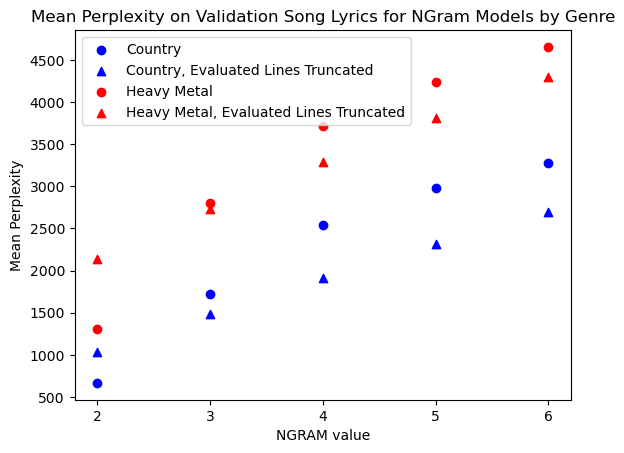

In [136]:
# visualize how NGRAM value impacts perplexity - MEAN 

# NGRAM value for our x-axis 
ngram_values = [2, 3, 4, 5, 6]
plt.xticks(ngram_values, ngram_values)

# Median Validation Perplexities for y-axis 
val_perplexities_country = [666, 1717, 2541, 2978, 3283]
val_perplexities_country_truncated = [1034, 1490, 1909, 2312, 2699]
val_perplexities_metal = [1303, 2799, 3717, 4239, 4656]
val_perplexities_metal_truncated = [2133, 2735, 3289, 3811, 4301]


plt.scatter(ngram_values, val_perplexities_country, marker='o',  color='blue', label='Country')
plt.scatter(ngram_values, val_perplexities_country_truncated, marker='^', color='blue', label='Country, Evaluated Lines Truncated')
plt.scatter(ngram_values, val_perplexities_metal, marker='o',  color='red', label='Heavy Metal')
plt.scatter(ngram_values, val_perplexities_metal_truncated, marker='^',  color='red', label='Heavy Metal, Evaluated Lines Truncated')


plt.xlabel('NGRAM value')
plt.ylabel('Mean Perplexity')
plt.title('Mean Perplexity on Validation Song Lyrics for NGram Models by Genre')
plt.legend()
plt.show()

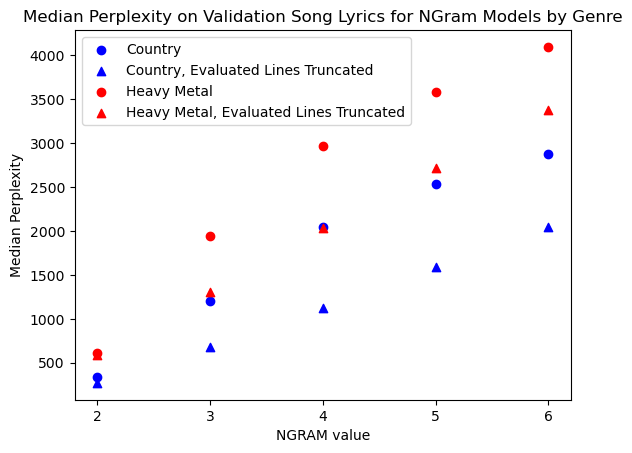

In [137]:
# visualize how NGRAM value impacts perplexity - MEDIAN 

# NGRAM value for our x-axis 
ngram_values = [2, 3, 4, 5, 6]
plt.xticks(ngram_values, ngram_values)

# Median Validation Perplexities for y-axis 
val_perplexities_country = [337, 1205, 2046, 2531, 2880]
val_perplexities_country_truncated = [270, 674, 1123, 1585, 2041]
val_perplexities_metal = [607, 1945, 2972, 3581, 4095]
val_perplexities_metal_truncated = [585, 1304, 2034, 2722, 3376]


plt.scatter(ngram_values, val_perplexities_country, marker='o',  color='blue', label='Country')
plt.scatter(ngram_values, val_perplexities_country_truncated, marker='^', color='blue', label='Country, Evaluated Lines Truncated')
plt.scatter(ngram_values, val_perplexities_metal, marker='o',  color='red', label='Heavy Metal')
plt.scatter(ngram_values, val_perplexities_metal_truncated, marker='^',  color='red', label='Heavy Metal, Evaluated Lines Truncated')


plt.xlabel('NGRAM value')
plt.ylabel('Median Perplexity')
plt.title('Median Perplexity on Validation Song Lyrics for NGram Models by Genre')
plt.legend()
plt.show()

##### Country Model 

__ngram=2__
1. mean perplexity on validation set: 666.4569538691799
1. mean perplexity on validation set, truncated lines: 701.5341622701865
1. median perplexity on validation set: 337.8503322927694
1. median perplexity on validation set, truncated lines: 347.2576093044937
4. example lyrics:\
love , oh wipe each other one without wishin that 's the by\
except what to realize\
put you take you\
he loved her mother\
no chance\
on and who i was there


__ngram=3__
1. mean perplexity on validation set: 1717.7441890763002
1. mean perplexity on validation set, truncated lines: 2088.222174434645
1. median perplexity on validation set: 1205.002805205404
1. median perplexity on validation set, truncated lines: 1334.1113495536927
4. example lyrics:\
i said i will\
and little jeanie 's sake .\
technicolor , river queen , three on high\
when a road with my fiddle\
yes everything i have shown

__ngram=4__
1. mean perplexity on validation set: 2541.1920928503173
1. mean perplexity on validation set, truncated lines: 1909.2102744689573
1. median perplexity on validation set: 2046.0507074046266
1. median perplexity on validation set, truncated lines: 1123.0440974636188
4. example lyrics:\
if heaven 's real\
i do n't know\
one night at a time\
well you nursed me through the valley filled with snow\
we always wear a great big world are we\
on a cloud nine ride


__ngram=5__
1. mean perplexity on validation set: 2977.679467657305
1. mean perplexity on validation set, truncated lines: 2312.154982133733
1. median perplexity on validation set: 2531.502204342474
1. median perplexity on validation set, truncated lines: 1585.0532742231758
4. example lyrics:\
lord above me knows i love you\
a beautiful sight , weæš®e happy tonight\
i get along with you\
however you look at it , whatever you believe\
she can crawl it\
'cause it 's beer thirty , and it 's time to go out on a huntin ' spree

__ngram=6__
1. mean perplexity on validation set: 3283.132530838534
1. mean perplexity on validation set, truncated lines: 2698.9866787870665
1. median perplexity on validation set: 2879.999449620529
1. median perplexity on validation set, truncated lines: 2040.811904729858
4. example lyrics:\
she do n't really care who 's watchin '\
you can count on me\
and you just ca n't get it through my head you do n't care at all\
i live with angel she 's a roadhouse queen\
you keep my tears flowing\
sing it sweet and sing it low

##### Heavy Metal Model

__ngram=2__
1. mean perplexity on validation set: 1302.8311168441328
1. mean perplexity on validation set, truncated lines: 1353.2622677013892
1. median perplexity on validation set: 606.7330883081569
1. median perplexity on validation set, truncated lines: 626.1042739182012
4. example lyrics:
out all you\
but i hide , hey , dokken ,\
lay you pain\
colder than you make me in fire\
learning life go


__ngram=3__
1. mean perplexity on validation set: 2798.635252641714
1. mean perplexity on validation set, truncated lines: 3346.9330566544186
1. median perplexity on validation set: 1944.8382552263183
1. median perplexity on validation set, truncated lines: 2241.9531404851023
4. example lyrics:\
oppressions wall they will learn\
mad magicians tinsel nightmares\
a thousand young\
wherever you are too much abuse of wasted human ... debris\
turning bottled water into wine


__ngram=4__
1. mean perplexity on validation set: 3717.5484844963134
1. mean perplexity on validation set, truncated lines: 3288.5812121694007
1. median perplexity on validation set: 2972.0462423487797
1. median perplexity on validation set, truncated lines: 2034.6472475929634
4. example lyrics:\
but now we retaliate\
devoid the fake with full disdain\
boiling in rage - sophisticated cage\
well , i know\
you feel it


__ngram=5__
1. median perplexity on validation set: 4239.426051074733
1. median perplexity on validation set, truncated lines: 3811.496829326747
1. mean perplexity on validation set: 3581.757352722282
1. mean perplexity on validation set, truncated lines: 2722.2028257501215
4. example lyrics:\
and now i close the door\
you will forger the pain\
ca n't somebody tell me am i the top of the chain\
just be my human hand\
death from above


__ngram=6__
1. mean perplexity on validation set: 4656.009183258817
1. mean perplexity on validation set, truncated lines: 4301.1671090754
1. median perplexity on validation set: 4095.8146685243028
1. median perplexity on validation set, truncated lines: 3375.9122626059634
4. example lyrics:\
confronting unconsciousness\
triumph awaits .\
i ’ ve had all i can take\
you lock me in\
tear down the veil

-------------------------------------------------------------------------------------------------------------------

Based on the validation perplexities and our own evaluation of how comprehensible the models' outputs are, we selected an NGRAM value of 4. We want the NGRAM value to be large enough to capture context and grammatical-correctness over a sequence. However, but we don't want the NGRAM value to be too large, as this will cause our generated sentences to be mimicked from the training data (since Shannon's method only produces seen n-grams, and song lyrics can sometimes be short). With our chosen NGRAM value, some sequences may be parroted, but we hope that we will generally produce varied and understandable sequences.